In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 
import nltk.stem.porter
porter_stemmer=nltk.stem.porter.PorterStemmer()
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
import nltk
from sklearn.metrics.pairwise import linear_kernel





# PREPROCESSING

In [2]:
#This function will extract raw message from the message object
def raw_message(raw_message):
    lines = raw_message.split('\n') #Here, the paragraph contains "\n" indicating the new line. Hence, the sentence tokenizer is not used.
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip() #removes all the spaces and appends only the text body to the variable "message"
            email['body'] = message
        else:
            pairs = line.split(':') #This enables to divide each sentence into 2 parts
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email  #returns an array with key-value pairs

In [3]:
def parse_into_emails(messages):
    emails = [raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'), 
        'to': map_to_list(emails, 'to'), 
        'from_': map_to_list(emails, 'from')
    }

In [4]:
def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [ ]:
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [ ]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

In [5]:
#reading the dataset
emails = pd.read_csv('split_emails.csv')

In [6]:
#creating a dataframe
email_df = pd.DataFrame(parse_into_emails(emails.message))


In [24]:
# Drop emails with empty body, to or from_ columns.
email_df.drop(email_df.query("body == '' | to == '' | from_ == ''").index, inplace=True)

In [25]:
#finding top words
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)
# max_df=0.5 means "ignore all terms that appear in more then 50% of the documents"
# min_df=2 means "ignore all terms that appear in less then 2 documents"

In [7]:
#email_df.head()

In [27]:
#stemming
body = email_df.body
def stemmingDF(body):
    bigl=[]
    for string in body:
        lis=string.split()
        l=[]
        for word in lis:
            if word.isalpha()==True:                
                if word not in stopwords:
                    if len(word)!=1:
                        word=word.lower()
                        word=lemmatizer.lemmatize(word)
                        l.append(word)
        str1=' '.join(l)
        bigl.append(str1)
    return bigl

email_df["body_new"] = stemmingDF(body)



In [8]:
#email_df.body_new[1]

In [31]:
#print top features
X = vect.fit_transform(email_df.body_new)
features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 1, 20))

      features     score
0     business  0.335930
1         trip  0.272305
2      meeting  0.252588
3   discussion  0.213792
4          try  0.192273
5    presenter  0.186883
6    stimulate  0.183843
7       speaks  0.181162
8       honest  0.181162
9        quiet  0.174613
10  productive  0.172791
11      flying  0.168064
12         ski  0.168064
13     desired  0.160814
14        boat  0.159802
15        golf  0.154526
16   traveling  0.148980
17         jet  0.148373
18     holding  0.139143
19  suggestion  0.138747


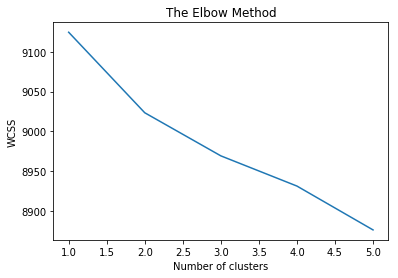

In [32]:
#kmeans clustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = []
for i in range(1, 6):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X.todense())
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 6), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [33]:
n_clusters = 3
clf = KMeans(n_clusters=n_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(X)

In [34]:
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()


In [35]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [36]:
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

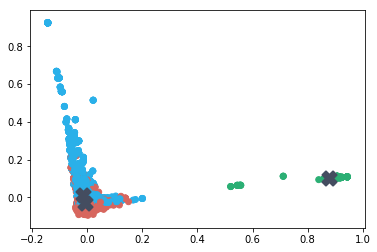

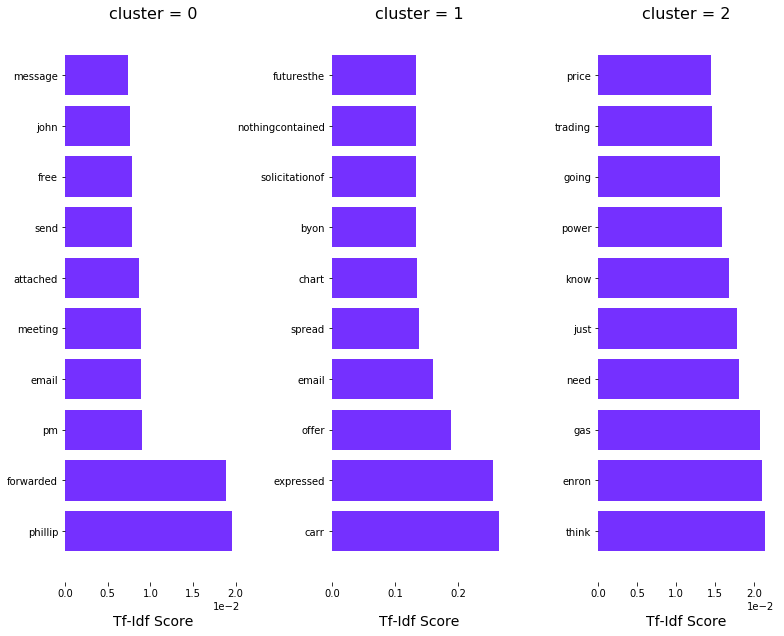

In [37]:
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

# Lets plot it again, but this time we add some color to it.
# This array needs to be at least the length of the n_clusters.
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]

plt.scatter(coords[:, 0], coords[:, 1], c=colors)
# Plot the cluster centers
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d60')
plt.show()

#Use this to print the top terms per cluster with matplotlib.
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 10))

In [38]:
def cos_score(lst):   
    leve_m=np.zeros([10,10])
    for i,word1 in enumerate(lst['features']):
        for j,word2 in enumerate(lst['features']):
            if word1!=word2:
                leve_m[i][j]=linear_kernel(lst['score'][i].reshape(-1,1),lst['score'][j].reshape(-1,1)).flatten()
    return leve_m.mean()

In [39]:
lst0=top_feats_per_cluster(X,labels,features,0.1,10)[0]
lst1=top_feats_per_cluster(X,labels,features,0.1,10)[1]
lst2=top_feats_per_cluster(X,labels,features,0.1,10)[2]

In [40]:
score0=cos_score(lst0)
score1=cos_score(lst1)
score2=cos_score(lst2)

In [41]:
print(score0)
print(score1)
print(score2)

9.611009577754558e-05
0.025117958053310435
0.00027907844365510336


In [43]:
X_new=X.todense()
from scipy.cluster import hierarchy
Z=hierarchy.linkage(X_new, 'ward')

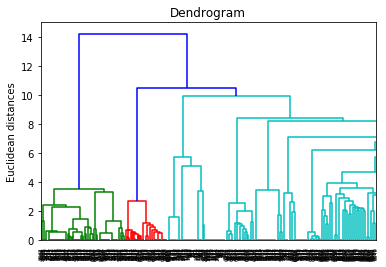

In [44]:
dn = hierarchy.dendrogram(Z)
#dendrogram=sch.dendrogram(sch,linkage(X,method='ward'))
plt.title('Dendrogram')
#plt.xlabel('Customers')
plt.ylabel('Euclidean distances')

plt.xlim(0,5000)
plt.ylim(0,15)
plt.show()


In [45]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_new)

In [ ]:
y_hc1=y_hc.astype(np.int32)

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
def cos_score(lst):   
    leve_m=np.zeros([10,10])
    for i,word1 in enumerate(lst['features']):
        for j,word2 in enumerate(lst['features']):
            if word1!=word2:
                leve_m[i][j]=linear_kernel(lst['score'][i].reshape(-1,1),lst['score'][j].reshape(-1,1)).flatten()
    return leve_m.mean()

In [ ]:
lst0=top_feats_per_cluster(X,y_hc1,features,0.1,10)[0]
lst1=top_feats_per_cluster(X,y_hc1,features,0.1,10)[1]
lst2=top_feats_per_cluster(X,y_hc1,features,0.1,10)[2]


In [ ]:
score0=cos_score(lst0)

score1=cos_score(lst1)
score2=cos_score(lst2)

In [ ]:
print(score0)
print(score1)
print(score2)